In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sys
sys.path.append('..')

from utils import metrics

### Load data

In [2]:
def get_last_N(series, N=18):
    """
    Get the last N points in a timeseries. If len(ts) < N, pad the difference with the first value.

    :param series: A timeseries
    :param N: Number of points to keep
    :return: A timeseries of length N
    """
    ser_N = series.dropna().iloc[-N:].values
    if len(ser_N) < N:
        pad = [ser_N[0]] * (N - len(ser_N))
        ser_N = np.r_[pad, ser_N]
    return ser_N

In [3]:
train_path = '../data/Yearly-train.csv'
test_path = '../data/Yearly-test.csv'

train_set = pd.read_csv(train_path).drop('V1', axis=1)
test_set = pd.read_csv(test_path).drop('V1', axis=1)

X_test = np.array([get_last_N(ser[1], N=18) for ser in train_set.iterrows()])
y_test = test_set.values


In [4]:
X_test.shape, y_test.shape

((23000, 18), (23000, 6))

### Load model

In [5]:
models = '../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/'

In [6]:
model7 = tf.keras.models.load_model(models + 'weights_epoch_007.h5')

In [7]:
model7.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 1)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 18, 256)           133120    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 18, 512)           1050624   
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 1536)              14157312  
_________________________________________________________________
reshape (Reshape)            (None, 6, 256)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 6, 1)             

### Generate predictions

In [8]:
preds = []

for x in tqdm(X_test):
    x = x.reshape(1, -1)
    mn, mx = x.min(axis=1).reshape(-1, 1), x.max(axis=1).reshape(-1, 1)
    x_sc = (x - mn) / (mx - mn)
    pred = model7(x_sc[..., np.newaxis])
    preds.append(pred[..., 0] * (mx - mn) + mn)

100%|██████████| 23000/23000 [22:24<00:00, 17.11it/s]


In [9]:
preds = np.array(preds)[:, 0, :]

In [10]:
preds.shape

(23000, 6)

In [11]:
inds = np.random.randint(len(X_test), size=16)

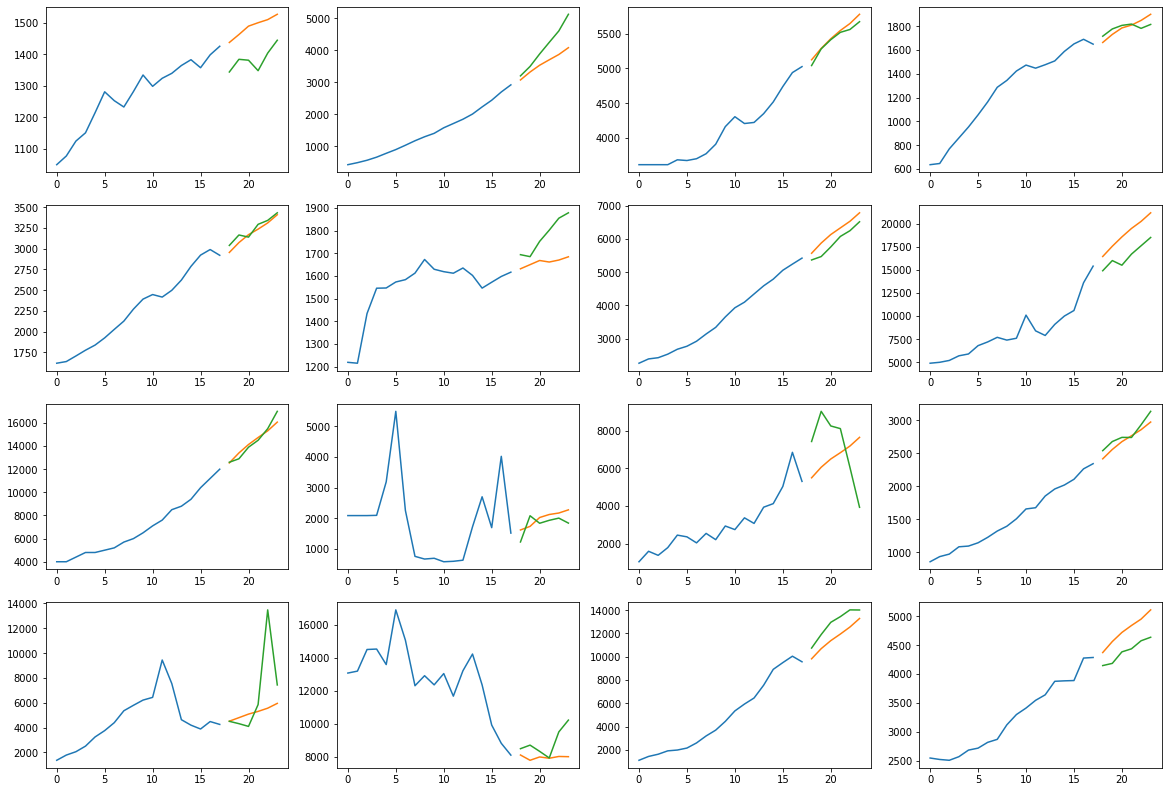

In [12]:
plt.figure(figsize=(20, 14))

for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    ax.plot(range(18), X_test[inds[i]])
    ax.plot(range(18, 24), preds[inds[i]])
    ax.plot(range(18, 24), y_test[inds[i]])

In [13]:
metrics.SMAPE(y_test, preds).mean()

13.32386220031002

### Test all models

In [14]:
model_paths = [models + 'weights_epoch_{:03d}.h5'.format(e) for e in range(15)]

In [15]:
model_preds = {}

for i, m in enumerate(model_paths):
    
    model = tf.keras.models.load_model(m)
    preds = []

    for x in tqdm(X_test, desc='model {}'.format(i)):
        x = x.reshape(1, -1)
        mn, mx = x.min(axis=1).reshape(-1, 1), x.max(axis=1).reshape(-1, 1)
        x_sc = (x - mn) / (mx - mn)
        pred = model(x_sc[..., np.newaxis])
        preds.append(pred[..., 0] * (mx - mn) + mn)
        
    model_preds[m] = np.array(preds)[0, :, 0]

model 14: 100%|██████████| 23000/23000 [17:21<00:00, 22.09it/s]


In [16]:
import pickle as pkl

with open('/tmp/analytical_preds.pkl', 'wb') as f:
    pkl.dump(model_preds, f)